<font size="+3"><strong>K-Means clustering</strong></font>

This notebook focuses on constructing a model aimed at segmenting households that have faced credit rejection or feared being rejected. Leveraging an unsupervised Machine Learning approach, specifically the K-means clustering model, the notebook explores the distinctions between these identified clusters. Visualization of the multi-dimensional clusters is achieved by utilizing principal component analysis (PCA)."

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import silhouette_score
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Import data and clean
df = pd.read_csv("data/scfp2022excel.zip")

# Subset the data to household where TURNFEAR = 1
df = df[df["TURNFEAR"] == 1]
print("df shape:", df.shape)
df.head()

df shape: (3839, 356)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
20,5,51,7191.481109,2,19,1,8,2,1,0,...,1,3,1,2,1,2,5,4,2,2
21,5,52,7352.487205,2,19,1,8,2,1,0,...,1,3,1,2,1,2,5,4,2,2
22,5,53,7270.703541,2,19,1,8,2,1,0,...,1,3,1,3,1,2,5,5,2,2
23,5,54,7383.866597,2,19,1,8,2,1,0,...,1,3,1,3,1,2,5,5,2,2
24,5,55,7330.537669,2,19,1,8,2,1,0,...,1,3,1,2,1,2,5,4,2,2


The plots below illustrate the relationships between various features within the dataset of individuals expressing credit fear. Notably, several distinct clusters can be observed.

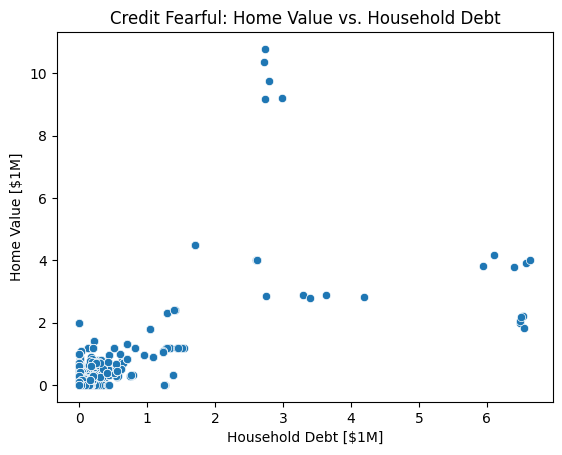

In [3]:
# Import data and clean
# "HOUSES" vs "DEBT"
sns.scatterplot(x = df["DEBT"] / 1e6, y = df["HOUSES"] / 1e6)

plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

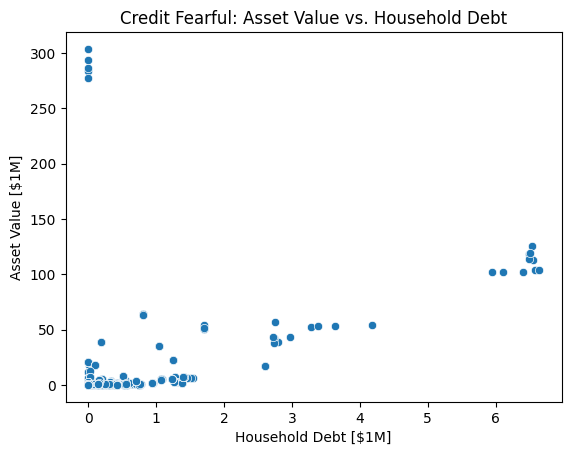

In [4]:
# "ASSET" vs "DEBT"
sns.scatterplot(x = df["DEBT"] / 1e6, y = df["ASSET"] / 1e6)

plt.xlabel("Household Debt [$1M]")
plt.ylabel("Asset Value [$1M]")
plt.title("Credit Fearful: Asset Value vs. Household Debt");

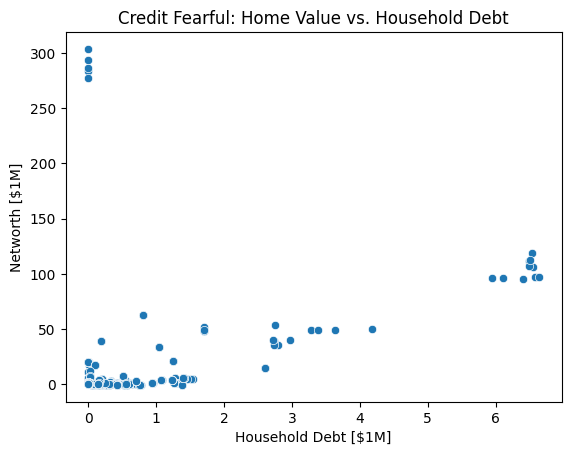

In [5]:
# Plot "NETWORTH" vs "DEBT"
sns.scatterplot(x = df["DEBT"] / 1e6, y = df["NETWORTH"] / 1e6)

plt.xlabel("Household Debt [$1M]")
plt.ylabel("Networth [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

To determine the most suitable features for clustering among the 356 available features in this project, the criterion I will be using is to identify numerical features with the highest variance. Features with the largest variance are considered for effective clustering.

In [6]:
# Calculating variance to get 10 largest features
top_ten_var = df.var().sort_values().tail(10)
top_ten_var

EQUITY      8.272191e+12
FIN         1.324553e+13
KGBUS       3.919372e+13
KGTOTAL     4.611527e+13
ACTBUS      6.441643e+13
BUS         7.182994e+13
NHNFIN      8.296348e+13
NFIN        8.582096e+13
NETWORTH    1.550844e+14
ASSET       1.599419e+14
dtype: float64

In [7]:
# Create horizontal bar chart of `top_ten_var`
fig = px.bar(
    x = top_ten_var,
    y = top_ten_var.index,
    title = "SCF: High Variance Features"
)

fig.update_layout(xaxis_title ="Variance", yaxis_title = "Feature")

fig.show()

One notable observation from the data exploration is the substantial skewness in many of the wealth indicators, where a handful of outlier households exhibit significant wealth. These outliers have the potential to influence the measure of variance. To investigate this, a box plot of one of the top high-variance features 'NETWORTH' is shown below:

In [8]:
# Create a boxplot of `NETWORTH`
fig = px.box(
    data_frame = df,
    x = "NETWORTH",
    title = "Distribution of Networth"
)

fig.update_layout(xaxis_title ="Value [$]")

fig.show()

In [9]:
# Filtering the dataset to include only individuals with a net worth less than $2 million to eliminate outliers.
mask = (df["NETWORTH"] < 2e6)
df = df[mask]

In [10]:
# Calculating variance to get the 10 largest features with the new values
top_ten_var = df.var().sort_values().tail(10)
top_ten_var
# Create horizontal bar chart of `top_ten_var`
fig = px.bar(
    x = top_ten_var,
    y = top_ten_var.index,
    title = "SCF: High Variance Features"
)

fig.update_layout(xaxis_title ="Variance", yaxis_title = "Feature")

fig.show()

In [11]:
# Create a boxplot of `ASSET`
fig = px.box(
    data_frame = df,
    x = "ASSET",
    title = "Distribution of Asset"
)

fig.update_layout(xaxis_title ="Value [$]")

fig.show()

The dataset exhibits a significant right-skewness, primarily due to the presence of substantial outliers on the right side of the distribution. To address this issue, a more robust approach involves examining the trimmed variance, where extreme values are excluded before calculating the variance."

In [12]:
# Calculating trimmed variance
top_ten_trim_var = df.apply(trimmed_var, limits = (0.1, 0.1)).sort_values().tail(10)
top_ten_trim_var

NH_MORT     9.661827e+08
MRTHEL      9.885072e+08
KGTOTAL     9.963638e+08
PLOAN1      1.120744e+09
HOMEEQ      1.494964e+09
DEBT        2.775392e+09
NETWORTH    5.946834e+09
HOUSES      6.387043e+09
NFIN        1.258410e+10
ASSET       1.751559e+10
dtype: float64

In [13]:
# Creating a horizontal bar chart of `top_ten_trim_var`
fig = px.bar(
    x = top_ten_trim_var,
    y = top_ten_trim_var.index,
    title = "SCF: High Variance Features"
)

fig.update_layout(xaxis_title ="Trimmed Variance", yaxis_title = "Feature")

fig.show()

There are three noteworthy observations in this plot.

Firstly, the variances have significantly decreased; in the previous chart, the x-axis extended up to \\$100 billion, whereas in this one, it only reaches \\$18 billion.

Secondly, there are alterations in the top 10 features, particularly with the exclusion of all features related to business ownership ("...BUS").

Lastly, substantial variations in variance among features are apparent. For instance, the variance for "NHMORT" is around \\$500 million, whereas the variance for "ASSET" is nearly \\$18 billion. In essence, these features exhibit markedly different scales, a factor that necessitates addressing before effective cluster formation.

In [14]:
# Generating a list with the column names of the  five features with the highest trimmed variance.
high_var_cols = top_ten_trim_var.tail(5).index.to_list()
high_var_cols

['DEBT', 'NETWORTH', 'HOUSES', 'NFIN', 'ASSET']

### **MODEL BUILDING**

##### Splitting Dataset

In [15]:
# Creating a feature matrix
X = df[high_var_cols]
print("X shape:", X.shape)
X.head()

X shape: (3672, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
20,11000,4100.0,0,14000.0,15100.0
21,10000,5500.0,0,14000.0,15500.0
22,10000,4500.0,0,13000.0,14500.0
23,10000,5600.0,0,14000.0,15600.0
24,11000,4500.0,0,14000.0,15500.0


##### **Iterate**

During the data exploration, it became apparent that a scale issue exists among the features. This discrepancy can pose challenges in clustering the data effectively, prompting the need for resolution to facilitate our analysis. One viable strategy for addressing this issue is **standardization**, a statistical method aimed at placing all variables in a dataset on the same scale.

The goal of standardization is to improve model performance having all continuous features be on the same scale. It's useful in at least two circumstances:
1. For machine leaning algorithms that use Euclidean distance (k-means and k-nearest neighbors), different scales can distort the calculation of distance and hurt model performance.
2. For dimensionality reduction (principal component analysis), it can improve the model's ability to finds combinations of features that have the most variance.


In [17]:
# Creating a dataframe to store the mean and std of our features
X_summary = X.agg(["mean", "std"])
X_summary

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
mean,72319.986383,104823.999891,86763.071895,140926.500163,177143.986275
std,141026.965379,258278.019155,183899.727419,266513.495317,332005.689330


In [18]:
# Scaling the values
# Instantiate transformer
ss = StandardScaler()

# Transform `X`
X_scaled_data = ss.fit_transform(X)

# Put `X_scaled_data` into DataFrame
X_scaled = pd.DataFrame(X_scaled_data, columns= X.columns)

print("X_scaled shape:", X_scaled.shape)
X_scaled.head()

X_scaled shape: (3672, 5)


,DEBT,NETWORTH,HOUSES,NFIN,ASSET
0,-0.434870,-0.390036,-0.47186,-0.476313,-0.488142
1,-0.441961,-0.384615,-0.47186,-0.476313,-0.486937
2,-0.441961,-0.388487,-0.47186,-0.480065,-0.489950
3,-0.441961,-0.384227,-0.47186,-0.476313,-0.486636
4,-0.434870,-0.388487,-0.47186,-0.476313,-0.486937


The five features have now been scaled and can be confirmed below:

In [19]:
X_scaled_summary = X_scaled.agg(["mean", "std"]).astype(int)
X_scaled_summary

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
mean,0,0,0,0,0
std,1,1,1,1,1


In [20]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for m in n_clusters:
    # Build model
    model = make_pipeline(StandardScaler(),
                         KMeans(n_clusters=m, random_state=42, n_init=10))

    # Fit model
    model.fit(X)

    # Get inertia scores
    inertia_errors.append(model.named_steps["kmeans"].inertia_)

    # Get silhouette scores
    silhouette_scores.append(silhouette_score(X, model.named_steps["kmeans"].labels_))
print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [8330.713703262294, 5668.1866930860415, 4638.1253291704215]

Silhouette Scores: [0.7623318800335575, 0.6991628816143209, 0.6816110141663074]


**Creating an elbow plot below to see how many clusters is best to use.**

In [21]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x = n_clusters, y=inertia_errors, title= "K-Means Model: Inertia vs Number of Clusters"
)

fig.update_layout(xaxis_title = "Number of Clusters", yaxis_title = "Inertia")
fig.show()

It can be seen that the line starts to flatten out around 4 to 6 clusters. Reviewing the silhouette_scores below:

In [22]:
# Creating a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x = n_clusters, y=silhouette_scores, title= "K-Means Model: Silhouette Score vs Number of Clusters"
)

fig.update_layout(
    xaxis_title="Number of Clusters", yaxis_title="Silhouette Score")

fig.show()

The silhouette score experiences a significant decline beyond 5 clusters, as evident from our observations and the inertia plot. Based on these findings, it appears that the optimal number of clusters is 4.

In [23]:
# Training a new K-means model with new parameter
kmeans_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=4, random_state=42, n_init=10)
)

kmeans_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, n_init=10, random_state=42))])

#### **MODEL'S RESULT**

In [24]:
# Extracting labels that the model created during training
labels = kmeans_model.named_steps["kmeans"].labels_
print(labels[:5])

[2 2 2 2 2]


In [25]:
# Creating a DataFrame xgb containing the mean values of the features in X for each of the clusters in the model
df_label = X.groupby(labels).mean()
df_label

,DEBT,NETWORTH,HOUSES,NFIN,ASSET
0,125867.398119,2.434314e+05,210700.626959,3.040773e+05,3.692988e+05
1,295479.848485,1.178737e+06,521022.727273,1.115614e+06,1.474217e+06
2,24488.532549,9.652937e+03,6850.680397,2.387923e+04,3.414147e+04
3,435343.879781,2.610102e+05,528770.491803,6.081538e+05,6.963541e+05


In [26]:
# Creating a side-by-side bar chart of the dataframe to visualize the clusters
fig = px.bar(
    df_label,
    barmode="group",
    title = "Mean Household Finances by Cluster"
)

fig.update_layout(xaxis_title="Cluster", yaxis_title="Value [$]")
fig.show()

It is significant to note that the clusters are partially defined by NETWORTH, with households in Cluster 2 having the smallest net worth, while those in Cluster 1 have the highest. Examining the DEBT variable within these clusters:

Despite the expectation that debt might scale with net worth, households in Cluster 1 exhibit a remarkably low debt scale compared to their net worth and assets, even though their house values are relatively close. One possible interpretation is that individuals in Cluster 1 have adequate funds to pay down their debts but not enough to engage in additional leveraging.

In Cluster 3, despite having the highest debt amount, there is a low net worth scale, suggesting a potentially precarious financial situation. The lower asset and house values in comparison to their debt might indicate that individuals in Cluster 3 carry a substantial debt burden relative to their overall financial standing, with fewer tangible assets to offset their liabilities. This interpretation points to a potential vulnerability in terms of financial stability for households in Cluster 3.

A notable observation in Cluster 0 is that these households maintain a significantly low level of debt compared to Clusters 1 and 3. Additionally, the net worth, house value, and debt within Cluster 0 are all roughly aligned on a similar scale. This could suggest a financial profile where individuals in Cluster 0 manage their debt conservatively, maintaining a balance between net worth, housing assets, and debt obligations.

Focusing on the relationship between DEBT and HOUSES, households in Cluster 2 exhibit debt values higher than the value of their houses, suggesting that a significant portion of their debt is tied up in mortgages, if they own a home at all. In contrast, the other three clusters show that the value of debt is lower than the value of their homes.

To effectively convey this information, the 5-dimensional data must be transformed into a format that can be visualized in two dimensions.

In [27]:
# Visualizing data in 2D
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns = ('PC1', 'PC2'))

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (3672, 2)


,PC1,PC2
0,-251204.231325,25992.793610
1,-250476.854167,27493.459458
2,-252087.985364,26975.015056
3,-250366.202109,27561.475569
4,-250761.623093,26264.858052


In [28]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    data_frame = X_pca,
    x = 'PC1',
    y = 'PC2',
    color = labels.astype('str'),
    title = 'PCA representation of clusters'
)

fig.update_layout(xaxis_title='PC1', yaxis_title='PC2')
fig.show()

**The above diagram is easier to understand and shows a 2D illustration that distinctly showcases four closely-knit clusters sharing common key features.**